# DeepWalk

The DeepWalk method (<span style="font-variant:small-caps;">Perozzi et al. (2014)</span>) is a network embedding method in the context of traditional link prediction methods. Network embedding methods learn low-dimensional representations, so-called embeddings, for nodes, often based on training a skip-gram model on random-walk-generated node sequences, so that nodes that often appear nearby each other in a random walk, i.e., nodes close in a network, have similar representations. Then, the pairwise node embeddings are aggregated as link representations for link prediction.

Note that DeepWalk is a special case of node2vec for the case of $p=q=1$.

DeepWalk is meant to serve as a baseline for later comparison with the three GNNs. It does not take node features into account.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.helpers import *
import pickle

import json
import os
import time
import random

import networkx as nx

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression

import node2vec_functions 
from gensim.models import Word2Vec

## Definition of helper functions

In [2]:
# Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    #np.random.seed(1234)
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean validation average precision is:', df_best[variable].unique()[0])

## Creation of graph and adjacency matrix

Our implementation of DeepWalk consists of different parts: we first create a node2vec graph instance and generate the walks, we then learn the word embeddings for the nodes in the training graph and create a node embeddings matrix and then use the node embeddings to obtain the edge embeddings, which are then used for link prediction.

As preliminary work, we first need to load the links of our original graph, create a networkx graph from them using `nx.Graph()` and calculate the adjacency matrix of this networkx graph, which comes in SciPy sparse format.

In [7]:
# read in all_links
with open('./all_links.txt', 'r') as f:
    all_links = json.loads(f.read())

In [8]:
# create graph and adjacency matrix
g = nx.Graph(all_links)
adj = nx.adjacency_matrix(g)

We now plot the graph to get a better impression of it.

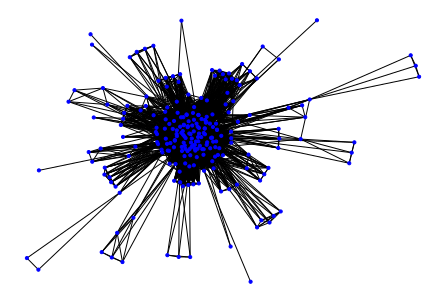

In [9]:
# draw network
np.random.seed(1234)
plt.figure(figsize=(6,4))
graph=nx.draw(g, with_labels=False, node_size=10, node_color='b')

It is evident that one group of HCPs has many connections to other HCPs, while another group of HCPs has only very few connections to other HCPs.

## Training loop

In our training loop, we use the following train-validation-test split: The training set contains a fraction of 0.6 of all 5821 links of our original graph, the validation set contains a fraction of 0.1 of all 5821 links of our original graph and the test set contains a fraction of 0.3 of all 5821 links of our original graph.

The 5821 links referred to above are links that actually exist and can therefore also be called *positive edges*. Links that do not actually exist in a graph are called *negative edges*.

In addition to the positive training, validation and test edges - called `train_edges`, `val_edges` and `test_edges` below, an equal number of negative training, validation and test edges - called `train_edges_false`, `val_edges_false` and `test_edges_false` below - are also extracted. The reason why negative edges are also extracted is that we want to determine not only how reliably the presence of a positive edge is predicted, but also how reliably the absence of a negative edge is predicted.  

We perform 10 runs with different train-validation-test splits, where the respective fractions of 0.6, 0.1 and 0.3 of course always remain unchanged.

The training loop calculates the validation AUCs and APs, test AUCs and APs in the 10 runs as well as the mean validation AUC and AP, mean test AUC and AP, standard deviation of validation AUCs and APs, standard deviation of test AUCs and APs over the 10 runs. We save all results in `dw_results`.

## Hyperparameter tuning

We use the functions from the file `node2vec_functions.py` and the [gensim implementation of Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html), where the first part is used to create a node2vec graph instance and generate the walks and the second part is used to train a skip-gram model.
With our DeepWalk implementation, the main hyperparameters to tune are:

* `window_size`: context size for optimization. Used in second part.
* `num_walks`: number of walks per source. Used in first part.
* `walk_length`: length of walk per source. Used in first part.
* `dimensions`: embedding dimension. Used in second part.

These hyperparameters are fixed: 

* `p`: set to 1 (to obtain DeepWalk).
* `q`: set to 1 (to obtain DeepWalk).
* `min_count` : set to 0 .
* `sg`: set to 1 (to obtain skip-gram model). 
* `iter`: set to 1.

Furthermore, we set `directed = False`, `verbose = False` to prevent excessive printing and `workers = 1` for reproducibility. 

There are still other hyperparameters that can be tuned. We do not tune them and instead rely on their default values provided in gensim. We now perform the hyperparameter tuning using loops.

Note that we need to seed with np and random and also in Word2Vec. In order for seeding to work in Word2vec, WORKERS = 1 must be set.

In [10]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [11]:
start_time = time.time()

dw_results = pd.DataFrame(columns = ['parameters', 'val_auc', 'val_ap', 'test_auc', 'test_ap', 'mean_val_auc', 'mean_val_ap', 
                                     'mean_test_auc','mean_test_ap', 'std_val_auc', 'std_val_ap', 'std_test_auc', 
                                     'std_test_ap'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

P = 1
Q = 1
is_directed = False
min_count = 0
sg = 1
WORKERS = 1 
ITER = 1
verbose = False

# Loops for hyperparameter tuning
for WINDOW_SIZE in [5, 10]: 
    for NUM_WALKS in [10, 20]: 
        for WALK_LENGTH in [40, 80]: 
            for DIMENSIONS in [16, 32, 64, 128]: 
        
                print(f'====================================================================================================\nParameter combination: {{WINDOW_SIZE: {WINDOW_SIZE}, NUM_WALKS: {NUM_WALKS}, WALK_LENGTH: {WALK_LENGTH}, DIMENSIONS: {DIMENSIONS}}}\n====================================================================================================')

                parameter_dict = dict({'WINDOW_SIZE': WINDOW_SIZE, 'NUM_WALKS': NUM_WALKS, 'WALK_LENGTH': WALK_LENGTH, 'DIMENSIONS': DIMENSIONS})

                val_auc_dict = dict()
                val_ap_dict = dict()
                test_auc_dict = dict()
                test_ap_dict = dict()

                for i, seed in enumerate(seeds):

                    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                    np.random.seed(seed)
                    random.seed(seed)

                    # Perform train-validation-test split
                    adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
                        test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)
                    g_train = nx.from_scipy_sparse_matrix(adj_train) 

                    # Preprocessing, generate walks
                    g_n2v = node2vec_functions.Graph(g_train, is_directed, P, Q) 
                    g_n2v.preprocess_transition_probs()
                    walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH, verbose)
                    walks = [list(map(str, walk)) for walk in walks] 

                    # Train skip-gram model
                    model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, min_count = min_count, sg = sg, workers = WORKERS, iter=ITER, seed=seed)

                    # Store embeddings mapping
                    emb_mappings = model.wv

                    # Create node embeddings matrix (rows = nodes, columns = embedding features)
                    emb_list = []
                    for node_index in range(0, adj.shape[0]):
                        node_str = str(node_index)
                        node_emb = emb_mappings[node_str]
                        emb_list.append(node_emb)
                    emb_matrix = np.vstack(emb_list)

                    # Train-set edge embeddings
                    pos_train_edge_embs = get_edge_embeddings(train_edges)
                    neg_train_edge_embs = get_edge_embeddings(train_edges_false)
                    train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

                    # Create train-set edge labels: 1 = real edge, 0 = false edge
                    train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

                    # Val-set edge embeddings, labels
                    pos_val_edge_embs = get_edge_embeddings(val_edges)
                    neg_val_edge_embs = get_edge_embeddings(val_edges_false)
                    val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
                    val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

                    # Test-set edge embeddings, labels
                    pos_test_edge_embs = get_edge_embeddings(test_edges)
                    neg_test_edge_embs = get_edge_embeddings(test_edges_false)
                    test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

                    # Create val-set edge labels: 1 = real edge, 0 = false edge
                    test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

                    # Train logistic regression classifier on train-set edge embeddings
                    edge_classifier = LogisticRegression()
                    edge_classifier.fit(train_edge_embs, train_edge_labels)

                    # Predicted edge scores: probability of being of class "1" (real edge)
                    val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
                    val_auc = roc_auc_score(val_edge_labels, val_preds)
                    val_ap = average_precision_score(val_edge_labels, val_preds)

                    # Predicted edge scores: probability of being of class "1" (real edge)
                    test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
                    test_auc = roc_auc_score(test_edge_labels, test_preds)
                    test_ap = average_precision_score(test_edge_labels, test_preds)

                    print(f'Validation AUC: {val_auc:.4f}, Validation AP: {val_ap:.4f}, Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

                    val_auc_dict.update({f"{i+1}": val_auc})
                    val_ap_dict.update({f"{i+1}": val_ap})    
                    test_auc_dict.update({f"{i+1}": test_auc})
                    test_ap_dict.update({f"{i+1}": test_ap})   

                data_concat = [{'parameters': parameter_dict, 'val_auc': val_auc_dict, 'val_ap': val_ap_dict, 'test_auc': test_auc_dict, 
                                'test_ap': test_ap_dict, 'mean_val_auc': mean(val_auc_dict.values()), 
                                'mean_val_ap': mean(val_ap_dict.values()), 'mean_test_auc': mean(test_auc_dict.values()), 
                                'mean_test_ap': mean(test_ap_dict.values()), 'std_val_auc': std(val_auc_dict.values()), 
                                'std_val_ap': std(val_ap_dict.values()), 'std_test_auc': std(test_auc_dict.values()), 
                                'std_test_ap': std(test_ap_dict.values())}]
                df_concat = pd.DataFrame(data_concat)
                dw_results = pd.concat([dw_results, df_concat], ignore_index=True)

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to dw_results.pkl")
dw_results.to_pickle(f"{route0}/dw_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {WINDOW_SIZE: 5, NUM_WALKS: 10, WALK_LENGTH: 40, DIMENSIONS: 16}
Run 1 with seed 12345:
Validation AUC: 0.7700, Validation AP: 0.7392, Test AUC: 0.7837, Test AP: 0.7571
Run 2 with seed 23456:
Validation AUC: 0.6824, Validation AP: 0.6653, Test AUC: 0.6910, Test AP: 0.6747
Run 3 with seed 34567:
Validation AUC: 0.7878, Validation AP: 0.7590, Test AUC: 0.7876, Test AP: 0.7613
Run 4 with seed 45678:
Validation AUC: 0.7398, Validation AP: 0.7363, Test AUC: 0.7571, Test AP: 0.7391
Run 5 with seed 56789:
Validation AUC: 0.8405, Validation AP: 0.8368, Test AUC: 0.8394, Test AP: 0.8357
Run 6 with seed 54321:
Validation AUC: 0.6463, Validation AP: 0.6096, Test AUC: 0.6662, Test AP: 0.6245
Run 7 with seed 65432:
Validation AUC: 0.7126, Validation AP: 0.6959, Test AUC: 0.7010, Test AP: 0.6909
Run 8 with seed 76543:
Validation AUC: 0.7665, Validation AP: 0.7625, Test AUC: 0.7287, Test AP: 0.7154
Run 9 with seed 87654:
Validation AUC: 0.8654, Validation AP: 0.8675, Test AUC: 

Validation AUC: 0.8405, Validation AP: 0.8460, Test AUC: 0.8399, Test AP: 0.8460
Run 6 with seed 54321:
Validation AUC: 0.6901, Validation AP: 0.5843, Test AUC: 0.6871, Test AP: 0.5752
Run 7 with seed 65432:
Validation AUC: 0.8048, Validation AP: 0.7539, Test AUC: 0.7837, Test AP: 0.7479
Run 8 with seed 76543:
Validation AUC: 0.7367, Validation AP: 0.6987, Test AUC: 0.7220, Test AP: 0.6742
Run 9 with seed 87654:
Validation AUC: 0.8781, Validation AP: 0.8872, Test AUC: 0.8629, Test AP: 0.8705
Run 10 with seed 98765:
Validation AUC: 0.8421, Validation AP: 0.8548, Test AUC: 0.8483, Test AP: 0.8634
Parameter combination: {WINDOW_SIZE: 5, NUM_WALKS: 10, WALK_LENGTH: 80, DIMENSIONS: 16}
Run 1 with seed 12345:
Validation AUC: 0.7457, Validation AP: 0.7197, Test AUC: 0.7548, Test AP: 0.7267
Run 2 with seed 23456:
Validation AUC: 0.8251, Validation AP: 0.8104, Test AUC: 0.8091, Test AP: 0.7933
Run 3 with seed 34567:
Validation AUC: 0.8417, Validation AP: 0.7916, Test AUC: 0.8421, Test AP: 0.814

Validation AUC: 0.7976, Validation AP: 0.8068, Test AUC: 0.8118, Test AP: 0.8080
Run 2 with seed 23456:
Validation AUC: 0.7940, Validation AP: 0.7856, Test AUC: 0.7665, Test AP: 0.7571
Run 3 with seed 34567:
Validation AUC: 0.8255, Validation AP: 0.8090, Test AUC: 0.8344, Test AP: 0.8198
Run 4 with seed 45678:
Validation AUC: 0.7545, Validation AP: 0.7274, Test AUC: 0.7718, Test AP: 0.7473
Run 5 with seed 56789:
Validation AUC: 0.8556, Validation AP: 0.8192, Test AUC: 0.8484, Test AP: 0.8301
Run 6 with seed 54321:
Validation AUC: 0.7711, Validation AP: 0.7738, Test AUC: 0.7597, Test AP: 0.7443
Run 7 with seed 65432:
Validation AUC: 0.8240, Validation AP: 0.8121, Test AUC: 0.8135, Test AP: 0.8107
Run 8 with seed 76543:
Validation AUC: 0.7707, Validation AP: 0.7570, Test AUC: 0.7467, Test AP: 0.7239
Run 9 with seed 87654:
Validation AUC: 0.8499, Validation AP: 0.8413, Test AUC: 0.8601, Test AP: 0.8537
Run 10 with seed 98765:
Validation AUC: 0.7359, Validation AP: 0.7137, Test AUC: 0.7456

Validation AUC: 0.8279, Validation AP: 0.8121, Test AUC: 0.8181, Test AP: 0.8105
Run 8 with seed 76543:
Validation AUC: 0.8232, Validation AP: 0.8154, Test AUC: 0.7899, Test AP: 0.7722
Run 9 with seed 87654:
Validation AUC: 0.8215, Validation AP: 0.7986, Test AUC: 0.8431, Test AP: 0.8257
Run 10 with seed 98765:
Validation AUC: 0.8123, Validation AP: 0.7955, Test AUC: 0.8368, Test AP: 0.8102
Parameter combination: {WINDOW_SIZE: 5, NUM_WALKS: 20, WALK_LENGTH: 40, DIMENSIONS: 128}
Run 1 with seed 12345:
Validation AUC: 0.8085, Validation AP: 0.8079, Test AUC: 0.8299, Test AP: 0.8224
Run 2 with seed 23456:
Validation AUC: 0.8037, Validation AP: 0.7779, Test AUC: 0.7782, Test AP: 0.7475
Run 3 with seed 34567:
Validation AUC: 0.8157, Validation AP: 0.7876, Test AUC: 0.8243, Test AP: 0.7993
Run 4 with seed 45678:
Validation AUC: 0.7914, Validation AP: 0.7617, Test AUC: 0.7993, Test AP: 0.7739
Run 5 with seed 56789:
Validation AUC: 0.8324, Validation AP: 0.7896, Test AUC: 0.8286, Test AP: 0.78

Validation AUC: 0.8421, Validation AP: 0.8130, Test AUC: 0.8222, Test AP: 0.7882
Run 3 with seed 34567:
Validation AUC: 0.8413, Validation AP: 0.7897, Test AUC: 0.8229, Test AP: 0.7879
Run 4 with seed 45678:
Validation AUC: 0.8256, Validation AP: 0.8040, Test AUC: 0.8245, Test AP: 0.7870
Run 5 with seed 56789:
Validation AUC: 0.8284, Validation AP: 0.7941, Test AUC: 0.8448, Test AP: 0.7995
Run 6 with seed 54321:
Validation AUC: 0.8255, Validation AP: 0.7931, Test AUC: 0.8184, Test AP: 0.7923
Run 7 with seed 65432:
Validation AUC: 0.8413, Validation AP: 0.8018, Test AUC: 0.8206, Test AP: 0.7842
Run 8 with seed 76543:
Validation AUC: 0.8767, Validation AP: 0.8627, Test AUC: 0.8478, Test AP: 0.8218
Run 9 with seed 87654:
Validation AUC: 0.8554, Validation AP: 0.8302, Test AUC: 0.8549, Test AP: 0.8238
Run 10 with seed 98765:
Validation AUC: 0.8010, Validation AP: 0.7576, Test AUC: 0.8307, Test AP: 0.8001
Parameter combination: {WINDOW_SIZE: 5, NUM_WALKS: 20, WALK_LENGTH: 80, DIMENSIONS: 12

Validation AUC: 0.7794, Validation AP: 0.7707, Test AUC: 0.7560, Test AP: 0.7547
Run 9 with seed 87654:
Validation AUC: 0.7991, Validation AP: 0.7764, Test AUC: 0.8105, Test AP: 0.7832
Run 10 with seed 98765:
Validation AUC: 0.7691, Validation AP: 0.7755, Test AUC: 0.7702, Test AP: 0.7626
Parameter combination: {WINDOW_SIZE: 10, NUM_WALKS: 10, WALK_LENGTH: 40, DIMENSIONS: 64}
Run 1 with seed 12345:
Validation AUC: 0.7713, Validation AP: 0.7645, Test AUC: 0.8035, Test AP: 0.8062
Run 2 with seed 23456:
Validation AUC: 0.7662, Validation AP: 0.7655, Test AUC: 0.7748, Test AP: 0.7777
Run 3 with seed 34567:
Validation AUC: 0.7751, Validation AP: 0.7703, Test AUC: 0.7853, Test AP: 0.7688
Run 4 with seed 45678:
Validation AUC: 0.7772, Validation AP: 0.7766, Test AUC: 0.7852, Test AP: 0.7820
Run 5 with seed 56789:
Validation AUC: 0.8095, Validation AP: 0.7822, Test AUC: 0.8081, Test AP: 0.7960
Run 6 with seed 54321:
Validation AUC: 0.7653, Validation AP: 0.7607, Test AUC: 0.7768, Test AP: 0.76

Validation AUC: 0.8226, Validation AP: 0.7692, Test AUC: 0.8099, Test AP: 0.7759
Run 4 with seed 45678:
Validation AUC: 0.7867, Validation AP: 0.7509, Test AUC: 0.7906, Test AP: 0.7494
Run 5 with seed 56789:
Validation AUC: 0.8320, Validation AP: 0.7834, Test AUC: 0.8252, Test AP: 0.7819
Run 6 with seed 54321:
Validation AUC: 0.7784, Validation AP: 0.7642, Test AUC: 0.7712, Test AP: 0.7543
Run 7 with seed 65432:
Validation AUC: 0.8209, Validation AP: 0.7880, Test AUC: 0.8142, Test AP: 0.7912
Run 8 with seed 76543:
Validation AUC: 0.7917, Validation AP: 0.7677, Test AUC: 0.7673, Test AP: 0.7297
Run 9 with seed 87654:
Validation AUC: 0.7873, Validation AP: 0.7520, Test AUC: 0.8014, Test AP: 0.7766
Run 10 with seed 98765:
Validation AUC: 0.7574, Validation AP: 0.7256, Test AUC: 0.7775, Test AP: 0.7449
Parameter combination: {WINDOW_SIZE: 10, NUM_WALKS: 10, WALK_LENGTH: 80, DIMENSIONS: 64}
Run 1 with seed 12345:
Validation AUC: 0.8008, Validation AP: 0.7712, Test AUC: 0.8214, Test AP: 0.79

Validation AUC: 0.7354, Validation AP: 0.6870, Test AUC: 0.7597, Test AP: 0.7146
Run 10 with seed 98765:
Validation AUC: 0.7426, Validation AP: 0.6998, Test AUC: 0.7768, Test AP: 0.7266
Parameter combination: {WINDOW_SIZE: 10, NUM_WALKS: 20, WALK_LENGTH: 40, DIMENSIONS: 32}
Run 1 with seed 12345:
Validation AUC: 0.7871, Validation AP: 0.7586, Test AUC: 0.7947, Test AP: 0.7596
Run 2 with seed 23456:
Validation AUC: 0.8016, Validation AP: 0.7872, Test AUC: 0.7703, Test AP: 0.7371
Run 3 with seed 34567:
Validation AUC: 0.7824, Validation AP: 0.7338, Test AUC: 0.7720, Test AP: 0.7269
Run 4 with seed 45678:
Validation AUC: 0.7594, Validation AP: 0.7187, Test AUC: 0.7673, Test AP: 0.7117
Run 5 with seed 56789:
Validation AUC: 0.7925, Validation AP: 0.7481, Test AUC: 0.7774, Test AP: 0.7283
Run 6 with seed 54321:
Validation AUC: 0.8093, Validation AP: 0.7767, Test AUC: 0.8017, Test AP: 0.7635
Run 7 with seed 65432:
Validation AUC: 0.8078, Validation AP: 0.7648, Test AUC: 0.8044, Test AP: 0.76

Validation AUC: 0.6414, Validation AP: 0.5815, Test AUC: 0.6688, Test AP: 0.6037
Run 5 with seed 56789:
Validation AUC: 0.7208, Validation AP: 0.6472, Test AUC: 0.7257, Test AP: 0.6606
Run 6 with seed 54321:
Validation AUC: 0.6941, Validation AP: 0.6495, Test AUC: 0.6655, Test AP: 0.6120
Run 7 with seed 65432:
Validation AUC: 0.7031, Validation AP: 0.6650, Test AUC: 0.7056, Test AP: 0.6545
Run 8 with seed 76543:
Validation AUC: 0.7402, Validation AP: 0.6681, Test AUC: 0.7110, Test AP: 0.6456
Run 9 with seed 87654:
Validation AUC: 0.7225, Validation AP: 0.6614, Test AUC: 0.7110, Test AP: 0.6489
Run 10 with seed 98765:
Validation AUC: 0.6590, Validation AP: 0.6085, Test AUC: 0.6921, Test AP: 0.6359
Parameter combination: {WINDOW_SIZE: 10, NUM_WALKS: 20, WALK_LENGTH: 80, DIMENSIONS: 32}
Run 1 with seed 12345:
Validation AUC: 0.7310, Validation AP: 0.6671, Test AUC: 0.7562, Test AP: 0.6996
Run 2 with seed 23456:
Validation AUC: 0.7266, Validation AP: 0.6700, Test AUC: 0.7164, Test AP: 0.66

Validation AUC: 0.7575, Validation AP: 0.7141, Test AUC: 0.7916, Test AP: 0.7490
saving file corresponding to dw_results.pkl
1 hours 40.92 minutes


In [12]:
# Look at results
dw_results = pd.read_pickle(f"{route0}/dw_results.pkl") 
dw_results

,parameters,val_auc,val_ap,test_auc,test_ap,mean_val_auc,mean_val_ap,mean_test_auc,mean_test_ap,std_val_auc,std_val_ap,std_test_auc,std_test_ap
0,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.7699661080998099, '2': 0.6824051440110...","{'1': 0.739170949705275, '2': 0.66530784779709...","{'1': 0.783664576469338, '2': 0.69101031452680...","{'1': 0.7570516152149801, '2': 0.6746516682096...",0.755437,0.739400,0.754532,0.737510,0.063391,0.071682,0.058946,0.068365
1,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.7505668331739115, '2': 0.7433515192309...","{'1': 0.7179709874137921, '2': 0.7468764297592...","{'1': 0.7682055793704216, '2': 0.7359554616082...","{'1': 0.7326634223578486, '2': 0.7351947193997...",0.770178,0.754803,0.767784,0.750627,0.049764,0.068513,0.048133,0.067181
2,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.7344002786929771, '2': 0.7368240809626...","{'1': 0.722336064983817, '2': 0.66233317976541...","{'1': 0.755289458871136, '2': 0.72449447534472...","{'1': 0.7394212817397062, '2': 0.6395565931747...",0.781514,0.756694,0.779458,0.753658,0.052616,0.081620,0.049729,0.081930
3,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.6945241553595256, '2': 0.7525094176970...","{'1': 0.638576055704462, '2': 0.66728625743195...","{'1': 0.7180483881337674, '2': 0.7353876443489...","{'1': 0.6631094225231224, '2': 0.6451958834892...",0.778599,0.739004,0.776345,0.737424,0.066216,0.103826,0.060459,0.101347
4,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.7456985628417236, '2': 0.8250522549332...","{'1': 0.7196804350929775, '2': 0.8103594479466...","{'1': 0.7548046328115057, '2': 0.8091386103927...","{'1': 0.7267299544519565, '2': 0.7932738548453...",0.790482,0.762263,0.785077,0.760979,0.052214,0.056623,0.050016,0.057001
5,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.809015599721307, '2': 0.83379388528713...","{'1': 0.8109878831565451, '2': 0.8195933962185...","{'1': 0.8281166967796789, '2': 0.8071448534303...","{'1': 0.8203331946874978, '2': 0.7896018073116...",0.814870,0.796704,0.812463,0.795846,0.033018,0.033277,0.035075,0.040893
6,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.8158441681132722, '2': 0.8274258688489...","{'1': 0.8199437985484103, '2': 0.8215729833026...","{'1': 0.8255147750577658, '2': 0.8034420682063...","{'1': 0.8191122197888925, '2': 0.7962673157119...",0.814796,0.799491,0.811278,0.797774,0.033634,0.037816,0.033692,0.038532
7,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 10, 'WALK_LENG...","{'1': 0.7975756072790826, '2': 0.7939561412831...","{'1': 0.8068456479283117, '2': 0.7856133229468...","{'1': 0.8117864560986395, '2': 0.7665034397064...","{'1': 0.8080295948996096, '2': 0.7571018356609...",0.797885,0.784597,0.795857,0.783386,0.038304,0.039284,0.040773,0.043414
8,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 20, 'WALK_LENG...","{'1': 0.7906791369964927, '2': 0.8131044744393...","{'1': 0.765977110214608, '2': 0.77412360083141...","{'1': 0.8088601142326298, '2': 0.7971668838215...","{'1': 0.7723618721893268, '2': 0.7648634474767...",0.797579,0.762341,0.804203,0.767853,0.021950,0.022402,0.024138,0.027609
9,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 20, 'WALK_LENG...","{'1': 0.7997632290596474, '2': 0.8475366374983...","{'1': 0.7913707256838816, '2': 0.8428151310249...","{'1': 0.8255200235130797, '2': 0.8245648046459...","{'1': 0.8135118768575091, '2': 0.8122920419069...",0.825319,0.803402,0.828587,0.805347,0.016861,0.019775,0.014177,0.014963


We can see that the mean AUC and AP values are nearly the same in the validation and test set. This shows us that the performance observable in the test set is reliable since it is corroborated by the performance in the validation set.

## Best hyperparameter combination

In [13]:
filter_best_hyperparameters(dw_results, 'mean_val_ap')

,parameters,val_auc,val_ap,test_auc,test_ap,mean_val_auc,mean_val_ap,mean_test_auc,mean_test_ap,std_val_auc,std_val_ap,std_test_auc,std_test_ap
15,"{'WINDOW_SIZE': 5, 'NUM_WALKS': 20, 'WALK_LENG...","{'1': 0.8379181870785655, '2': 0.8498128269623...","{'1': 0.8202504427324493, '2': 0.8168689610380...","{'1': 0.8483366989053034, '2': 0.8211926721066...","{'1': 0.8206342496307729, '2': 0.7815836267398...",0.845627,0.815102,0.84166,0.808294,0.015306,0.01961,0.014141,0.019746


In [14]:
print_best_hyperparameters(dw_results, 'mean_val_ap')

The best hyperparameter combination/s is/are:
	 {'WINDOW_SIZE': 5, 'NUM_WALKS': 20, 'WALK_LENGTH': 80, 'DIMENSIONS': 128} 
The resulting validation average precision is: 0.8151016148726139


The best hyperparameter value leads to the highest mean validation AP of 0.8151.

So, our best hyperparameter value is given by:

* WINDOW_SIZE = 5
* NUM_WALKS = 20
* WALK_LENGTH = 80
* DIMENSIONS = 128

The mean validation AP is 0.8151 and the mean test AP is 0.8083. The standard deviation of the test APs of 0.0197 is about as high as the standard deviation of the validation APs of 0.0196.